# Prostate cANcer graDe Assessment (PANDA) Challenge: My First Submission

# Introduction

## Prostate Gland and Prostate Cancer

The prostate is part of the male reproductive system. The function of the prostate gland is to secrete substances to the urethra. These secretions nurish and transport sperm. Prostate cancer is diagnosed from samples from a prostate biopsy (rmicrobe). The sample is first assigned as a gleason score. This score is converted to a ISUP grade of 0-5. The score of 0 is negative and the score of 5 is the most severe form of cancer (Prostate cANcer GraDe Assessment (PANDA) Challenge).

The purpose of this notebook is to create a submission notebook for the PANDAS competition.

## Predicting Test Data and Submitting submission.csv

1. Commit current version and create submission.csv.
2. Submit the current notebook to the competition to access the testing data.  The code will run in the background to evaluate the test dataset.  The test dataset will undergo the same image processing as the training dataset and is described in the next  following steps.
2. Remove gray area surrounding the biopsy. The first step involves removing the gray area from around the biopsy (Zenify).
3. Create 4X4 patched image. The second step is to take 16 samples that have the lowest portion of white. This ensures that the sample is most likely going to show the appropriate part of the sample (i.e. glands). (PAB97).
4. Use test.pkl file to predict the test images.
5. Arrange the test biopsies to the appropriate order. 
6. Create and save the predictions to a .csv for submission.

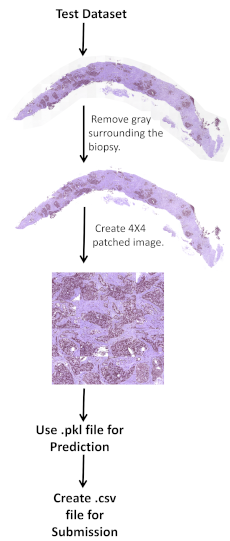

# Import fast.ai and Dependencies

## Install fast.ai without Internet

Internet is not allowed in this competition.  The files have to be loaded through the fastai2 dataset.

In [ ]:
!pip install ../input/fastai2/fastprogress-0.2.3-py3-none-any.whl
!pip install ../input/fastai2/fastcore-0.1.18-py3-none-any.whl
!pip install ../input/fastai2/fastai2-0.0.17-py3-none-any.whl

## Import fast.ai

In [ ]:
import fastai2

In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

In [ ]:
fastai2.torch_core.defaults.device = 'cuda'

## Load Dependencies

In [ ]:
import os
import cv2
import PIL
from PIL import Image as Img
from PIL import ImageTk
import random
import openslide
import skimage.io
import skimage.color
from skimage.color import rgb2hsv
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Set Random Seed

Setting a random seed makes sure that all randomly picked sequences are in the same order.  It is important to keep the same number everytime to keep the same sequence everytime.

In [ ]:
np.random.seed(2)

# Functions

The enhance_image function removes the gray portion from around the prostate biopsy (Zenify).

In [ ]:
def enhance_image(slide_path, contrast=1, brightness=15):
    image = skimage.io.MultiImage(slide_path)[-2]
    image = np.array(image)
    img_enhanced = cv2.addWeighted(image, contrast, image, 0, brightness)
    return img_enhanced

The function compute_statistics calculates the portion of white pixels in the region (PAB97).

In [ ]:
def compute_statistics(image):
    width, height = image.shape[0], image.shape[1]
    num_pixels = width * height
    
    num_white_pixels = 0
    
    summed_matrix = np.sum(image, axis=-1)
    # Note: A 3-channel white pixel has RGB (255, 255, 255)
    num_white_pixels = np.count_nonzero(summed_matrix > 620)
    ratio_white_pixels = num_white_pixels / num_pixels
    
    green_concentration = np.mean(image[1])
    blue_concentration = np.mean(image[2])
    
    return ratio_white_pixels, green_concentration, blue_concentration


The functions select_k_best_regions and get_k_best_regions list and select the lowest porportion of white pixels in a particular region (PAB97).

In [ ]:
def select_k_best_regions(regions, k=20):
    regions = [x for x in regions if x[3] > 180 and x[4] > 180]
    k_best_regions = sorted(regions, key=lambda tup: tup[2])[:k]
    return k_best_regions

In [ ]:
def get_k_best_regions(coordinates, image, window_size=512):
    regions = {}
    for i, tup in enumerate(coordinates):
        x, y = tup[0], tup[1]
        regions[i] = image[x : x+window_size, y : y+window_size, :]
    
    return regions

The function generate_patches slides over the region to calculate the white pixels then calculates the statistics and then selects the region with the least amount of pixels (PAB97).

In [ ]:
def generate_patches(image, window_size=200, stride=128, k=20):
        
    max_width, max_height = image.shape[0], image.shape[1]
    regions_container = []
    i = 0
    
    while window_size + stride*i <= max_height:
        j = 0
        
        while window_size + stride*j <= max_width:            
            x_top_left_pixel = j * stride
            y_top_left_pixel = i * stride
            
            patch = image[
                x_top_left_pixel : x_top_left_pixel + window_size,
                y_top_left_pixel : y_top_left_pixel + window_size,
                :
            ]
            
            ratio_white_pixels, green_concentration, blue_concentration = compute_statistics(patch)
            
            region_tuple = (x_top_left_pixel, y_top_left_pixel, ratio_white_pixels, green_concentration, blue_concentration)
            regions_container.append(region_tuple)
            
            j += 1
        
        i += 1
    
    k_best_region_coordinates = select_k_best_regions(regions_container, k=k)
    k_best_regions = get_k_best_regions(k_best_region_coordinates, image, window_size)
    
    return image, k_best_region_coordinates, k_best_regions

The function glue_to_one_picture glues the 16 patches into one 4X4 image (PAB97).

In [ ]:
def glue_to_one_picture(image_patches, window_size=200, k=16):
    side = int(np.sqrt(k))
    image = np.zeros((side*window_size, side*window_size, 3), dtype=np.int16)
        
    for i, patch in image_patches.items():
        x = i // side
        y = i % side
        image[
            x * window_size : (x+1) * window_size,
            y * window_size : (y+1) * window_size,
            :
        ] = patch
    
    return image

In [ ]:
WINDOW_SIZE = 128
STRIDE = 64
K = 16

# Checkpoints Directory

This creates a checkpoint directory for ResNet34 and copies the model to the directory.

In [ ]:
Path('/root/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp '../input/resnet34/resnet34.pth' '/root/.cache/torch/checkpoints/resnet34-333f7ec4.pth'

# Predict the ISUP Grade with ResNet34 and fast.ai using export.pkl

The steps will be described using comments.

In [ ]:
torch.cuda.is_available()

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
submission_test_path = "../input/prostate-cancer-grade-assessment/test_images/"
sample = '../input/prostate-cancer-grade-assessment/sample_submission.csv'
source = Path("../input/prostate-cancer-grade-assessment")

In [ ]:
#This is the dataframe for sample_submission.csv.
sub_df = pd.read_csv(sample)

# This is the dataframe for test.csv.
test_df = pd.read_csv(source/f'test.csv')

# If the submission_test_path exists, evaluate the test data and create the submission.csv file for the competition.
#Else, create the submission.csv file to get access to the testing data.
if os.path.exists(submission_test_path):
    #get_i is a function that processes the images.
    def get_i(df=test_df):
            filename = f'{submission_test_path}/{df.image_id}.tiff'
            enhanced_image = enhance_image (filename)
            image, best_coordinates, best_regions = generate_patches(enhanced_image, window_size=WINDOW_SIZE, stride=STRIDE, k=K)
            glued_image = glue_to_one_picture(best_regions, window_size=WINDOW_SIZE, k=K)
            glued_image = np.uint8(glued_image)
            return tensor(glued_image)
        
    #This part prepares the image without adding the label since this is test data.
    blocks = (
          ImageBlock,
          CategoryBlock
              )
    getters = [
           get_i
              ]

    trends = DataBlock(blocks=blocks,
              getters=getters,
              item_tfms=Resize(520)
              )
    
    dls = trends.dataloaders(test_df)
    
    # This loads the export.pkl file.    
    learn = load_learner ('../input/train-and-create-test-pkl-file/test.pkl')
    
    #This predicts the data from the train dataset and the validation dataset.
    predictionIndex1= []
    num = len (dls.train_ds)
    
    for i in range(num):
        predictionIndex1.append (learn.predict(dls.train_ds[i][0]))
    
    singlepredictionIndex1 = []
    num = len(predictionIndex1)

    for i in range(num):
        singlepredictionIndex1.append (predictionIndex1[i][0])
    
    prediction_df1 = dls.train_ds.items
    
    prediction_df1 = prediction_df1.assign(Prediction=singlepredictionIndex1)
    
        
    predictionIndex2= []
    num = len (dls.valid_ds)
    
    for i in range(num):
        predictionIndex2.append (learn.predict(dls.valid_ds[i][0]))
    
    singlepredictionIndex2 = []
    num = len(predictionIndex2)

    for i in range(num):
        singlepredictionIndex2.append (predictionIndex2[i][0])
    
    prediction_df2 = dls.valid_ds.items
    
    prediction_df2 = prediction_df2.assign(Prediction=singlepredictionIndex2)
    
    #Append and order the predictions to prepare the dataframe to be exported.
    prediction_df = prediction_df1.append(prediction_df2, ignore_index=False)
    
    prediction_df = prediction_df.sort_index (ascending = True)
    
    prediction_df = prediction_df.reset_index()
    
    prediction_df = prediction_df[['image_id', 'Prediction']]
    
    prediction_df = prediction_df.rename({'Prediction':'isup_grade'}, axis=1)
    
    #Export to .csv.
    prediction_df.to_csv ('submission.csv', index = False)
    


else:
    #File to commit so notebook can access the test data.
    sub_df.to_csv("submission.csv", index=False)


# Works Cited

Amrit Virdee. "Fastai2 | Balanced | Stratified | Submission ✔" Kaggle, June 30, 2020, https://www.kaggle.com/avirdee/fastai2-balanced-stratified-submission.

PAB97. “Better image tiles - Removing white spaces.” Kaggle, 22 May 2020, www.kaggle.com/rftexas/better-image-tiles-removing-white-spaces.

“Prostate CANcer GraDe Assessment (PANDA) Challenge.” Kaggle, www.kaggle.com/c/prostate-cancer-grade-assessment/overview/description.

rmicrobe. “Microanatomy of the Prostate.” Kaggle, 11 June 2020, www.kaggle.com/rmicrobe/microanatomy-of-the-prostate.

Zenify. “Let's Enhance the Images!” Kaggle, 03 May 2020, www.kaggle.com/debanga/let-s-enhance-the-images.